# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

## Импорты

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import torch
import transformers

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer
from tqdm import tqdm, notebook
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
from pymystem3 import Mystem

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [6]:
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

In [7]:
from catboost import CatBoostClassifier
import time
import catboost as cb

In [8]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
pip install nltk -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
from nltk.corpus import wordnet

In [13]:
# Зададим отображение всех колонок

pd.set_option("display.max.columns", None)

In [14]:
# Зададим отображение десятичных знаков

pd.options.display.float_format = '{:.3f}'.format

In [15]:
# Определим random_state и test_size

RANDOM_STATE = 45
VALID_SIZE = 0.4
TEST_SIZE_2 = 0.5
TEST_SIZE = 0.25


In [16]:
pip install pandarallel -q

Note: you may need to restart the kernel to use updated packages.


In [17]:
from pandarallel import pandarallel
tqdm.pandas(desc="progress")
pandarallel.initialize(progress_bar = True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [18]:
!/opt/conda/bin/python -m pip install wordcloud -q

In [19]:
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2 -q

In [20]:
!pip install --upgrade Pillow -q

In [21]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Подготовка

### Загрузка данных

In [22]:
# Загружаем файл

df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

#На случай работы локально

if os.path.exists('/datasets/toxic_comments.csv'):
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
elif os.path.exists(r'C:\Users\melyakova_sv\Desktop\CM\Yandex\DataSets\toxic_comments.csv'):
    df = pd.read_csv(r'C:\Users\melyakova_sv\Desktop\CM\Yandex\DataSets\toxic_comments.csv', index_col=[0])
else:
    print('Файл не найден')

In [23]:
# Выведем первые 5 строк

df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [24]:
# Приведем в порядок индексы

df.reset_index(drop=True, inplace=True)

In [25]:
# Проверим

df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [26]:
# Выведем размер файла

df.shape

(159292, 2)

In [27]:
# Общая информация

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Пропусков нет. Значения соответствуют типам данных.

In [28]:
# Проверим значения в целевой колонке

df.toxic.unique()

array([0, 1])

Посмотрим соотношение классов в целевом признаке

In [29]:
rate = df.toxic.value_counts().to_frame()
rate['rates'] = round((rate.toxic/df.shape[0])*100,2)
rate

,toxic,rates
0,143106,89.840
1,16186,10.160


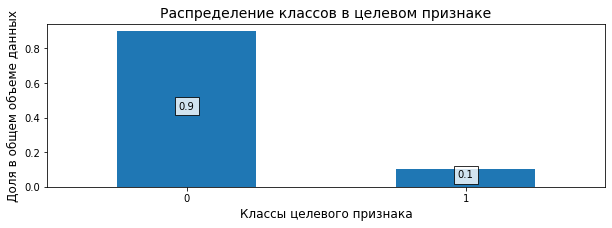

In [30]:
# Посмотрим это на графике:

fig, axs = plt.subplots( figsize=(10,3))
df.toxic.value_counts(normalize=True).plot(kind='bar',  rot=0)
axs.set_title('Распределение классов в целевом признаке', fontsize=14)
axs.set_xlabel('Классы целевого признака', fontsize=12)
axs.set_ylabel('Доля в общем объеме данных', fontsize=12)

for i in range(df.toxic.nunique()):
        plt.text(i,df.toxic.value_counts(normalize=True)[i]/2, 
                 round(df.toxic.value_counts(normalize=True)[i],2), ha = 'center', 
                 bbox = dict(facecolor = 'white', alpha =0.8))     

plt.show();

В нашем файле есть дисбаланс классов. Но это не недостаток, а особенность данных (токисчных комментариев меньше, чем нормальных)

### Подготовка данных

Проверим, какие данные содержатся в колонке текст

In [31]:
df.text.sample(35)

56150     Anyways, wheres LittleLuckyLinks page? - User:...
73193     starcraft 2 isnt even out yet. But hell, he's ...
123175    from 0Waldo \nWhy did you just revert my link?...
97060                  Please don't block. Everything is ok
46345                            equal or greater than zeor
63027     con stalkers. Some idiot in Vancouver simply c...
147390    "\n\n This is a map of the East India Company ...
9462      licences \n\nJust a note of scepticism relatin...
54999     Ah, thank you for the fast reply.  On MSN Mess...
46584     I suppose we can say that the canvassed RfC is...
140436    "\nYou don't get it. You're too involved with ...
72188     "\n\nThanks, it appears that at least someone ...
134497                 Fuck veritas this school sucks dick!
113209    ya \n\nyou cna stop before your banned from wi...
67800     Now \n\nI still think you are doo doo.\n\nYes,...
32343     Hi Rex, nice to meet you. ) Kinda was feeling ...
139448    If you're a motherf**king a**h

В тексте много посторонних символов, которые следует удалить.

Проведем очистку текста от лишних символов и лемматизацию 

In [32]:
# Функция для очистки и лемматизации текста

def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r'("?:=\n|\r,].)', ' ', text)

    return text

In [33]:
# Применим функцию

df['lemm_text'] = df['text'].apply(clear_text)

In [34]:
# Функция для определения POS-tags для лемматизатора

def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

In [35]:
# Определим стоп-слова (язык английский)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Инициализируем лемматизатор

lemmatizer = WordNetLemmatizer()

In [37]:
# Функция для лемматизации текста

def lemm_text(text):
    
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stopwords]
    text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text])
    
    return text

In [38]:
# Применим функцию

df['lemm_text'] = df['lemm_text'].apply(lemm_text)

In [39]:
df.head(3)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...


In [40]:
# Проверим на случайном наборе, не осталось ли каких-то лишних символов

df.sample(35)

,text,toxic,lemm_text
113294,Your edit to User_Talk:Martyman\nPlease stop. ...,0,edit user talk martyman please stop continue v...
37971,The file is non-free and a non-free file needs...,0,file non free non free file need non free use ...
16260,WHAT KIND OF NAME IS PRAIRIEWOOD??????? \n\nAL...,1,kind name prairiewood shit name evil happen ma...
39729,"Um... \n\nMy edit was cited, dumbass. Did you ...",1,um edit cite dumbass even listen source revert
100642,", please stop pushing lopsided POV - prove the...",0,please stop push lopsided pov prove hangul pha...
53663,"""::If I remember correctly, Kilo 6-4 was the c...",0,remember correctly kilo command control bird g...
64546,"Frickin' vandals. Hunt 'em down, Admins please...",1,frickin vandal hunt em admins please racooon
27394,It wasn't vandalism it was perfectly justified...,0,vandalism perfectly justified find extremely i...
2210,"""\n\n Some baklava for you! \n\n Fuck . =) """,1,baklava fuck
145123,"""\nSince she does have controversial statement...",0,since controversial statement race include bit...


Разделим данные на тренировочную и тестовую выборки

In [41]:
X = df['lemm_text'] # признаки
y = df['toxic'] # таргет

In [42]:
# разбиваем датасет на тренировочную, валидационную и тестовую выборки

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=VALID_SIZE, random_state=RANDOM_STATE, stratify = y)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=TEST_SIZE_2, 
                                                    random_state=RANDOM_STATE, stratify = y_valid)

In [43]:
#Проверим размер выборок

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(95575,) (95575,) (31858,) (31858,) (31859,) (31859,)


In [44]:
# Проверим, что строки не потерялись

X_train.shape[0]+X_valid.shape[0], X_test.shape[0]==df.shape[0]

(127433, False)

Векторизируем данные в выборках

In [45]:
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

In [46]:
tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_valid = count_tf_idf.transform(X_valid)
tf_idf_test = count_tf_idf.transform(X_test)

In [47]:
print(tf_idf_train.shape, tf_idf_valid.shape, tf_idf_test.shape)

(95575, 111830) (31858, 111830) (31859, 111830)


## Обучение

### Базовая модель LogisticRegression

Рассмотрим базовую модель

In [48]:
# Инициализация модели

lr_base = LogisticRegression(random_state=45)

In [49]:
# Обучение модели

lr_base.fit(tf_idf_train, y_train)

LogisticRegression(random_state=45)

In [50]:
# Предсказания модели

pred_lr_train = lr_base.predict(tf_idf_train)
pred_lr_valid = lr_base.predict(tf_idf_valid)

# Метрика

f1_lr_base_train = round(f1_score(y_train, pred_lr_train),4)
print(f'Метрика базовой LogisticRegression на тренировочной выборке: {f1_lr_base_train}')

f1_lr_base_valid = cross_val_score(lr_base, tf_idf_valid, y_valid, scoring = "f1", cv = 5).mean()
print(f'Метрика базовой LogisticRegression на валидационной выборке: {f1_lr_base_valid}')

Метрика базовой LogisticRegression на тренировочной выборке: 0.7527
Метрика базовой LogisticRegression на валидационной выборке: 0.613128786419229


### LogisticRegression с подбором параметров

In [51]:
# Инициализация модели

model_lr = LogisticRegression(fit_intercept=True, random_state=RANDOM_STATE)

In [52]:
# Зададим гиперпараметры для поиска лучшей модели

param_lr = [
    # словарь для модели LogisticRegression()
    {
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1', 'l2'],
        'C': range(1,7)
    }
]

In [53]:
# Зададим поиск гиперпараметров

best_lr = RandomizedSearchCV(
    model_lr, 
    param_lr, 
    scoring = 'f1', 
    cv=5,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

In [54]:
# Обучение модели

best_lr.fit(tf_idf_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=45),
                   n_jobs=-1,
                   param_distributions=[{'C': range(1, 7),
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear', 'saga']}],
                   random_state=45, scoring='f1')

In [55]:
print(f'Лучшие параметры LogisticRegression: \n\n', best_lr.best_params_, '\n\n')

Лучшие параметры LogisticRegression: 

 {'solver': 'saga', 'penalty': 'l1', 'C': 4} 




Лучшая модель и ее параметры: 

 {'solver': 'saga', 'penalty': 'l1', 'class_weight': None, 'C': 6} 

In [56]:
# Предсказания модели

pred_lr_param_train = best_lr.best_estimator_.predict(tf_idf_train)
pred_lr_param_valid = best_lr.best_estimator_.predict(tf_idf_valid)

# Метрика

f1_lr_param_train = round(f1_score(y_train, pred_lr_param_train),4)
print(f'Метрика LogisticRegression с лучшими параметрами на тренировочной выборке: {f1_lr_param_train}')

f1_lr_param_valid = cross_val_score(best_lr.best_estimator_, tf_idf_valid, y_valid, scoring = "f1", cv = 5).mean()
print(f'Метрика LogisticRegression с лучшими параметрами на валидационной выборке: {f1_lr_param_valid}')

Метрика LogisticRegression с лучшими параметрами на тренировочной выборке: 0.882
Метрика LogisticRegression с лучшими параметрами на валидационной выборке: 0.743741272391929


### RandomForestClassifier

In [57]:
# Инициализация модели

model_rfclf = RandomForestClassifier(random_state=RANDOM_STATE)

In [58]:
#Зададим гиперпараметры для поиска лучшей модели

param_rfclf = [
    
    # словарь для модели RandomForestClassifier() 
    { 
        'max_depth': range(1, 5), 
        'min_samples_leaf': range(1, 5), 
        'max_features': range(1, 5)
    }
]

Подберем лучшую модель с помощью RandomizedSearchCV

In [59]:
# Зададим поиск гиперпараметров

best_rfclf = RandomizedSearchCV(
    model_rfclf, 
    param_rfclf, 
    scoring = 'f1', 
    cv=5,
    random_state=RANDOM_STATE, 
    #n_jobs=-1 # Для деревянных моделей это параметр не нужен
)

In [60]:
# Обучение модели

best_rfclf.fit(tf_idf_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45),
                   param_distributions=[{'max_depth': range(1, 5),
                                         'max_features': range(1, 5),
                                         'min_samples_leaf': range(1, 5)}],
                   random_state=45, scoring='f1')

In [61]:
print(f'Лучшие параметры RandomForestClassifier: \n\n', best_rfclf.best_params_, '\n\n')

Лучшие параметры RandomForestClassifier: 

 {'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 2} 




In [62]:
# Предсказания модели

pred_rfclf_train = best_rfclf.best_estimator_.predict(tf_idf_train)
pred_rfclf_valid = best_rfclf.best_estimator_.predict(tf_idf_valid)

# Метрика

f1_rfclf_train = round(f1_score(y_train, pred_rfclf_train),4)
print(f'Метрика LogisticRegression с лучшими параметрами на тренировочной выборке: {f1_rfclf_train}')

f1_rfclf_valid = cross_val_score(best_rfclf.best_estimator_, tf_idf_valid, y_valid, scoring = "f1", cv = 5).mean()
print(f'Метрика LogisticRegression с лучшими параметрами на валидационной выборке: {f1_rfclf_valid}')

Метрика LogisticRegression с лучшими параметрами на тренировочной выборке: 0.0
Метрика LogisticRegression с лучшими параметрами на валидационной выборке: 0.0


### CatBoostClassifier

REM: это была хорошая идея, но дождаться, когда она посчитается, я не смогла :(((

In [64]:
#Инициализация модели

model_cbc = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

In [65]:
#Зададим гиперпараметры для поиска лучшей модели

param_cbc = [
    # словарь для модели CatBoostClassifier()
    {
        'depth': range(1, 5),
        'learning_rate': np.arange(0.1, 0.3, 0.1),
        'n_estimators': range(50, 150, 50)
    }
]

Подберем лучшую модель с помощью RandomizedSearchCV

In [67]:
#Зададим поиск гиперпараметров

best_cbc = RandomizedSearchCV(
    model_cbc, 
    param_cbc, 
    scoring = 'f1', 
    cv=5,
    random_state=RANDOM_STATE, 
    verbose=False
    #n_jobs=-1 # Для деревянных моделей это параметр не нужен
)

In [68]:
#Обучение модели

best_cbc.fit(tf_idf_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7efd2bcb4ee0>,
                   param_distributions=[{'depth': range(1, 5),
                                         'learning_rate': array([0.1, 0.2]),
                                         'n_estimators': range(50, 150, 50)}],
                   random_state=45, scoring='f1', verbose=False)

In [69]:
print(f'Лучшие параметры CatBoostClassifier: \n\n', best_cbc.best_params_, '\n\n')

Лучшие параметры CatBoostClassifier: 

 {'n_estimators': 100, 'learning_rate': 0.2, 'depth': 4} 




In [70]:
# Предсказания модели

pred_cbc_train = best_cbc.best_estimator_.predict(tf_idf_train)
pred_cbc_valid = best_cbc.best_estimator_.predict(tf_idf_valid)

# Метрика

f1_cbc_train = round(f1_score(y_train, pred_cbc_train),4)
print(f'Метрика LogisticRegression с лучшими параметрами на тренировочной выборке: {f1_cbc_train}')

f1_cbc_valid = cross_val_score(best_cbc.best_estimator_, tf_idf_valid, y_valid, scoring = "f1", cv = 5).mean()
print(f'Метрика LogisticRegression с лучшими параметрами на валидационной выборке: {f1_cbc_valid}')

Метрика LogisticRegression с лучшими параметрами на тренировочной выборке: 0.6779
Метрика LogisticRegression с лучшими параметрами на валидационной выборке: 0.6517508248555428


## Выводы

In [76]:
# Соберем итоги

models = pd.DataFrame({'model_name': ['LogisticRegression (base)', 'LogisticRegression (param)', 'RandomForestClassifier (param)',
                                 'CatBoostClassifier (param)'],
                       'F1_train': [f1_lr_base_train, f1_lr_param_train, f1_rfclf_train, f1_cbc_train],
                       'F1_valid': [f1_lr_base_valid, f1_lr_param_valid, f1_rfclf_valid, f1_cbc_valid],
                       'model': [lr_base, best_lr.best_estimator_, best_rfclf.best_estimator_, best_cbc.best_estimator_]
                                })
models.sort_values(by = 'F1_valid', ascending=False)

,model_name,F1_train,F1_valid,model
1,LogisticRegression (param),0.882,0.744,"LogisticRegression(C=4, penalty='l1', random_s..."
3,CatBoostClassifier (param),0.678,0.652,<catboost.core.CatBoostClassifier object at 0x...
0,LogisticRegression (base),0.753,0.613,LogisticRegression(random_state=45)
2,RandomForestClassifier (param),0.000,0.000,"(DecisionTreeClassifier(max_depth=2, max_featu..."


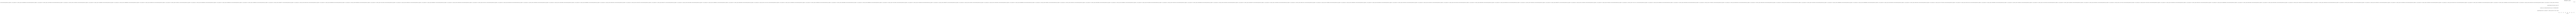

In [81]:
# Визуализация

models.sort_values('F1_valid', ascending=False).plot(
    x='model', y='F1_valid', kind='barh', color='LightBlue', edgecolor='black');

plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('F1_valid'); plt.xticks(size = 12);
plt.title('Метрики F1_valid', size = 14);

In [83]:
print(f'Лучшей моделью получается: {models.sort_values(by="F1_valid", ascending=False).head(1)}')

Лучшей моделью получается:                    model_name  F1_train  F1_valid  \
1  LogisticRegression (param)     0.882     0.744   

                                               model  
1  LogisticRegression(C=4, penalty='l1', random_s...  


In [86]:
# Проверка лучшей модели на тестовых данных

f1_best_lr_test = round(f1_score(y_test, best_lr.best_estimator_.predict(tf_idf_test)),4)
print(f'Метрика лучшей модели на тестовой выборке: ', round(f1_best_lr_test, 5))

Метрика лучшей модели на тестовой выборке:  0.7833


Метрика получилась около 0,78, что отвечает условиям задачи.